 # SILO GeoTIFF Download and Visualization Demo



 This notebook demonstrates the Cloud-Optimized GeoTIFF (COG) functionality

 in the `weather_tools` package.

 We'll download rainfall data for a specific region in South Australia over

 the past 9 days using reduced resolution (overview level) and visualize

 the results.



 ## Key Features Demonstrated



 - **Spatial subsetting**: Download only data within a polygon boundary

 - **Overview levels**: Use pyramid overviews for reduced resolution (faster downloads)

 - **Time series**: Retrieve multiple days of data efficiently

 - **HTTP range requests**: COG files allow downloading only the pixels we need

 ## Setup and Imports

In [1]:
from datetime import date, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from shapely.geometry import Polygon

from weather_tools.silo_geotiff import read_geotiff_timeseries


 ## Define the Study Area



 We'll use a polygon in South Australia as our area of interest.

In [2]:
# Coordinates for the polygon (longitude, latitude)
coords = [
    [136.0, -32.0],
    [136.0, -36.2],
    [140.0, -36.2],
    [140.0, -32.0],
    [136.0, -32.0],
]

# Create a Shapely Polygon object
study_area = Polygon(coords)

print(f"Study area bounds: {study_area.bounds}")


Study area bounds: (136.0, -36.2, 140.0, -32.0)


 ## Define the Date Range



 We'll download the past 9 days of rainfall data ending yesterday

 (today's data may not yet be available).

In [3]:
# Calculate date range (past 9 days)
end_date = date.today() - timedelta(days=1)  # Yesterday
start_date = end_date - timedelta(days=8)  # 9 days total

print(f"Date range: {start_date} to {end_date}")
print(f"Number of days: {(end_date - start_date).days + 1}")


Date range: 2025-10-21 to 2025-10-29
Number of days: 9


 ## Download Rainfall Data



 Using `read_geotiff_timeseries()`, we'll:

 - Query only the `daily_rain` variable

 - Clip to our polygon geometry

 - Use `overview_level=2` for 4× reduced resolution (faster, smaller file sizes)

 - Stream directly from S3 without caching to disk (`save_to_disk=False`)



 **Note**: Overview levels work by powers of 2:

 - `overview_level=0`: 2× reduced resolution

 - `overview_level=1`: 4× reduced resolution

 - `overview_level=2`: 8× reduced resolution



 For this demo, we'll use level 1 (4× reduction) to balance speed and detail.

In [4]:
print("Downloading rainfall data from SILO S3...")

data = read_geotiff_timeseries(
    variables=["daily_rain"],
    start_date=start_date,
    end_date=end_date,
    geometry=study_area,
    save_to_disk=False,  # Stream from S3, don't cache
    overview_level=1,  # 4× reduced resolution
)

rainfall = data["daily_rain"]
print(f"\nDownloaded data shape: {rainfall.shape}")
print(f"  - Time steps: {rainfall.shape[0]}")
print(f"  - Height: {rainfall.shape[1]} pixels")
print(f"  - Width: {rainfall.shape[2]} pixels")



Downloaded data shape: (9, 42, 40)
  - Time steps: 9
  - Height: 42 pixels
  - Width: 40 pixels


 ## Visualize the Results



 Plot each day's rainfall as a 3×3 grid with a shared color scale.

 - Grey background indicates no data or masked values (ocean areas)

Shared colorbar scale: 0 to 40.40 mm


/var/folders/b0/wq9x9vj13dv_75w41x6dmcyh0000gn/T/ipykernel_42040/1710477305.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis").copy()


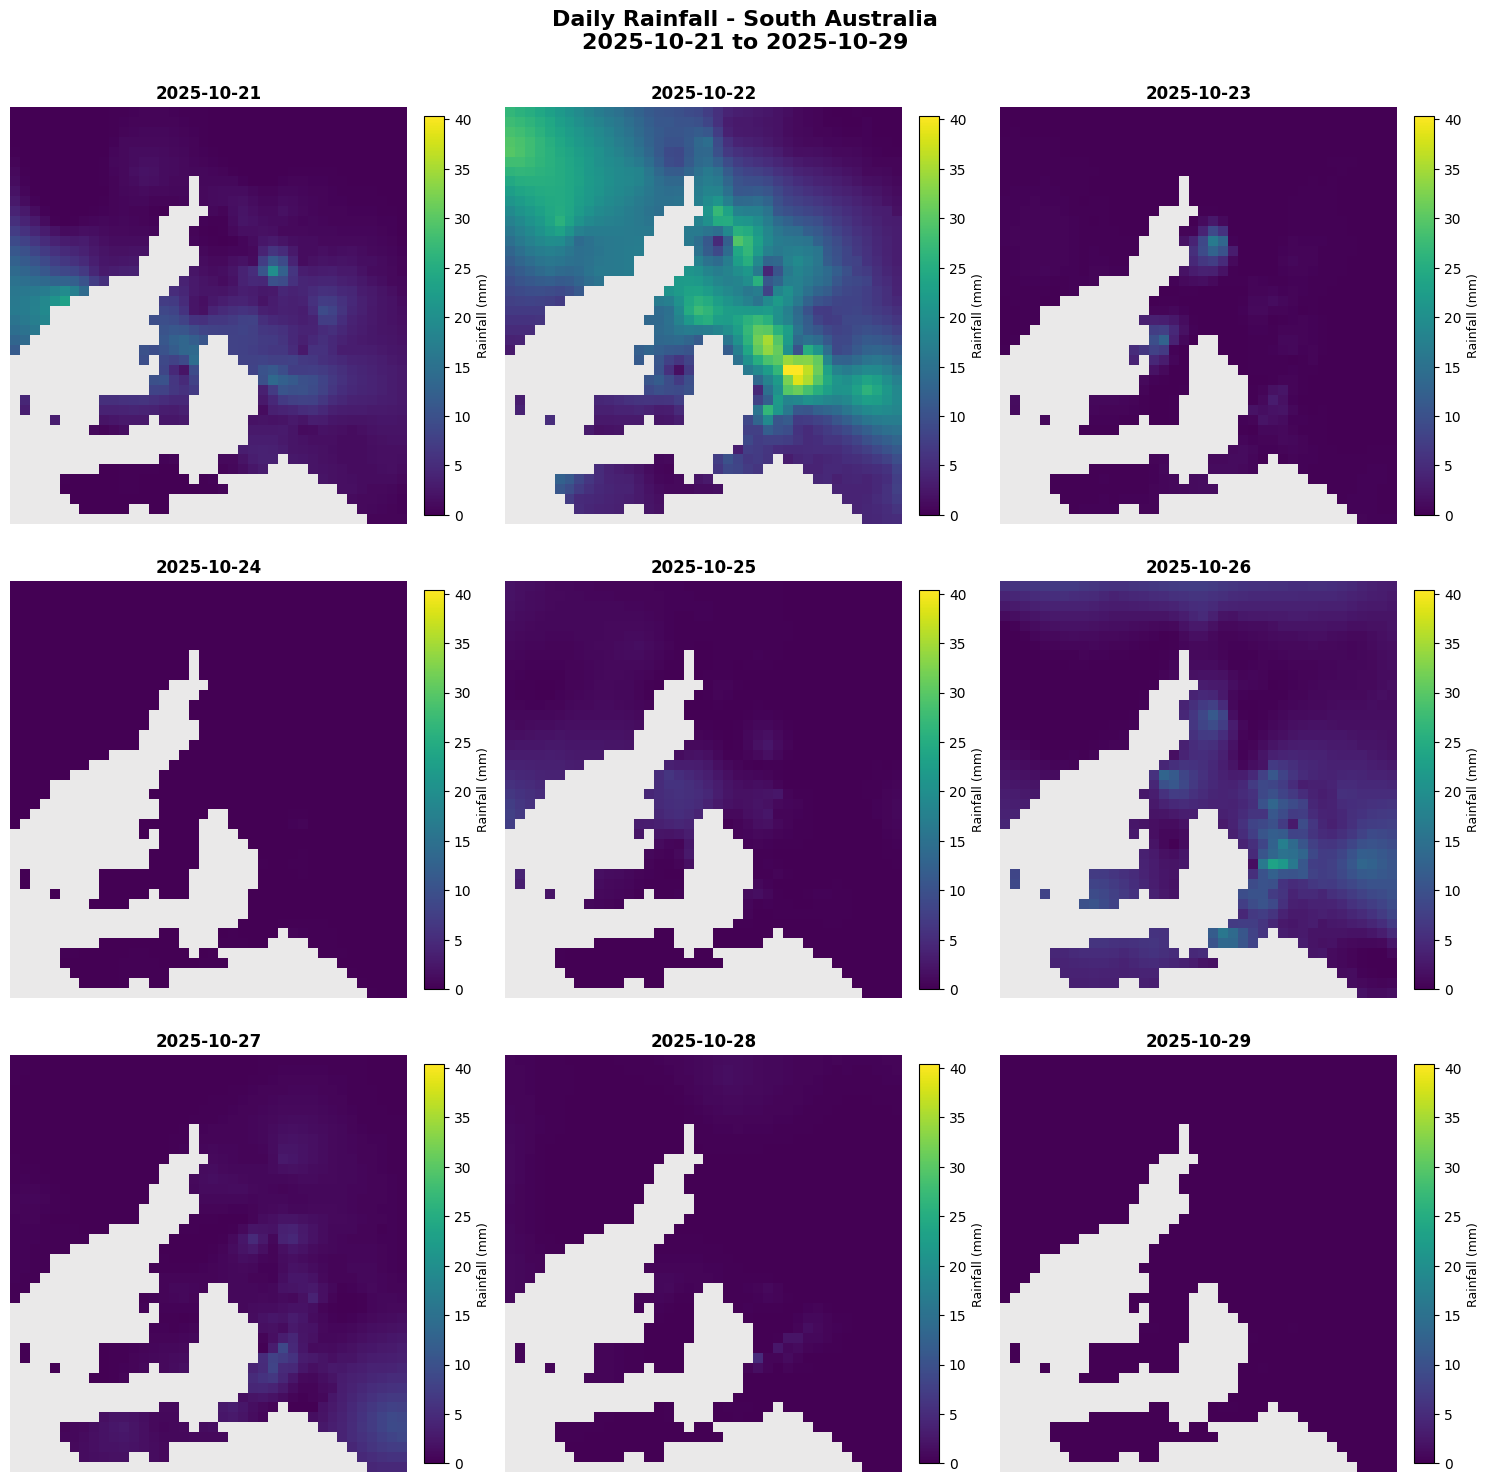

In [5]:
# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Generate date labels
date_list = [start_date + timedelta(days=i) for i in range(9)]

# Calculate global min/max for shared colorbar scale
# First, clean all the data and collect valid values
all_valid_values = []
cleaned_rainfall = []

for day_data in rainfall:
    day_cleaned = day_data.copy()
    day_cleaned[day_cleaned < 0] = np.nan  # Set negative values to NaN
    cleaned_rainfall.append(day_cleaned)

    # Collect non-NaN values
    valid = day_cleaned[~np.isnan(day_cleaned)]
    if len(valid) > 0:
        all_valid_values.extend(valid.flatten())

# Determine shared scale
if all_valid_values:
    vmin = 0  # Rainfall minimum is always 0
    vmax = np.max(all_valid_values)
else:
    vmin, vmax = 0, 1  # Fallback if no valid data

print(f"Shared colorbar scale: 0 to {vmax:.2f} mm")

# Create custom colormap with grey background for NaN values
cmap = cm.get_cmap("viridis").copy()
cmap.set_bad(color="#EAE9E9")  # Grey for missing/NaN data

# Plot each day with shared scale
for idx, (ax, day_data, day_date) in enumerate(zip(axes, cleaned_rainfall, date_list)):
    # Create the plot with shared vmin/vmax and custom colormap
    im = ax.imshow(day_data, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
    ax.set_title(f"{day_date.strftime('%Y-%m-%d')}", fontsize=12, fontweight="bold")
    ax.axis("off")

    # Add colorbar (all will show the same scale)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Rainfall (mm)", fontsize=9)

plt.suptitle(
    f"Daily Rainfall - South Australia\n{start_date} to {end_date}",
    fontsize=16,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()


 ## Summary Statistics

In [6]:
# Calculate statistics across the entire period
stats_data = []

for idx, day_date in enumerate(date_list):
    day_data = rainfall[idx]
    day_data[day_data < 0] = np.nan  # Clean negative values
    valid_data = day_data[~np.isnan(day_data)]

    if len(valid_data) > 0:
        stats_data.append(
            {
                "Date": day_date.strftime("%Y-%m-%d"),
                "Mean (mm)": np.mean(valid_data),
                "Median (mm)": np.median(valid_data),
                "Max (mm)": np.max(valid_data),
                "Min (mm)": np.min(valid_data),
            }
        )
    else:
        stats_data.append(
            {
                "Date": day_date.strftime("%Y-%m-%d"),
                "Mean (mm)": np.nan,
                "Median (mm)": np.nan,
                "Max (mm)": np.nan,
                "Min (mm)": np.nan,
                "Std Dev (mm)": np.nan,
                "Total (mm)": np.nan,
            }
        )

# Create DataFrame and display
stats_df = pd.DataFrame(stats_data)
print("\nRainfall Statistics Summary:")
print(stats_df.to_string(index=False, float_format="%.2f"))



Rainfall Statistics Summary:
      Date  Mean (mm)  Median (mm)  Max (mm)  Min (mm)
2025-10-21       2.77         1.40     23.10      0.00
2025-10-22      12.50        11.70     40.40      0.00
2025-10-23       0.43         0.10     16.70      0.00
2025-10-24       0.02         0.00      0.50      0.00
2025-10-25       0.70         0.20      7.60      0.00
2025-10-26       3.48         2.80     23.40      0.00
2025-10-27       1.06         0.60      9.00      0.00
2025-10-28       0.21         0.10      4.90      0.00
2025-10-29       0.01         0.00      0.20      0.00


/Users/hfsi/Developer/weather_tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


 ## Key Takeaways



 1. **Efficient Downloads**: Using COG overview levels and spatial subsetting, we downloaded

    only the data we needed without retrieving full continental grids.



 2. **HTTP Range Requests**: The entire operation used HTTP range requests to fetch only

    relevant pixels from S3, avoiding unnecessary data transfer.



 3. **No Local Storage**: With `save_to_disk=False`, we streamed data directly into memory

    without creating local cache files.



 4. **Flexible Geometries**: The same approach works with any Shapely geometry (Point, Polygon,

    MultiPolygon, etc.).



 ## Next Steps



 - Use `save_to_disk=True` with a `cache_dir` to cache files for reuse

 - Download multiple variables simultaneously (e.g., `["daily_rain", "max_temp", "min_temp"]`)